In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import json
from itertools import product

from keras.models import Sequential, load_model
from keras.layers import *

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback

import matplotlib.pyplot as plt
plt.style.use('seaborn')

Using TensorFlow backend.


# Summary
I'm fitting the keras' embedding layer for a few epochs within the possibly simplest imaginable setup, namely with global averaging and softmax on top. This fairly inexpensive but broad examination serves to produce reasonable starting embeddings for more complicated net architectures and to compare various loss-functions/batch-sizes/optimizers. The choice of loss function is a somewhat non-trivial matter due to the class imbalance of our dataset and the stated objective of maximazing the macroF1 score.

* Results land in the directory defined in the *working_dir* variable below.
* Weights are stores as *blabla_weights.p* and they may be directly depickled into the *weights* argument of the Embedding layer (see the *Embedding* within *init* of the *BlackBox* class). 
* There are nice plots below.

We manage to establish an interesting benchmark for our dataset: the simple setup described above is almost enough to reproduce the perfomarmance of shallow classifiers, *macroF1*=80%. For other net architectures to carry their weight, they'll have to go beyond that.

---

### Load the data in
The test data is not used

In [2]:
global_params = pickle.load(open("global_params.p", "rb"))
unique_words = global_params['unique_words']
num_words = global_params['num_words']
padded_length = global_params['padded_length']
n_classes = global_params['n_classes']
class_weights = global_params['class_weights']

global_params

{'unique_words': 277303,
 'num_words': 277304,
 'padded_length': 679,
 'n_classes': 6,
 'class_weights': array([ 1.26825655,  0.72736371,  0.27602776, 13.23801959, 30.29201502,
         9.49559404])}

In [23]:
n_sample = 100_000

In [50]:
X_train = np.load(os.path.join("data", "Kdata", "X_train.npy"))
y_train = np.load(os.path.join("data", "Kdata", "y_train.npy"))
X_val = np.load(os.path.join("data", "Kdata", "X_val.npy"))
y_val = np.load(os.path.join("data", "Kdata", "y_val.npy"))

---

### Some custom definitions
* metrics
* loss functions
* choice of learning parameters and settings

In [51]:
from keras import backend as K


def macroPrec(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    positives = K.sum(K.round(y_pred), axis=0)
    precision = true_positives / (positives + K.epsilon())

    macroPrec = K.mean( precision )
    
    return macroPrec


def macroRecall(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    macroRecall = K.mean( recall )
    
    return macroRecall


def macroF1(y_true, y_pred):

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    
    actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=0)
    precision = true_positives / (positives + K.epsilon())
    
    macroF1 = 2 * K.mean( precision*recall / (precision + recall + K.epsilon()) )
    
    return macroF1



# Custom loss functions
# No clippping or rounding as those are not differentiable
# Those will be computed per batch of course, so it would be nice for batches
# to be large enough to contain a good statistic of all the classes.
# Note to self: these functions are already taking into account class imbalances, so remeber
# not to set the class_weight argument in fitting method when using them as the loss 

# semi macroF1
def fuzzy_macroF1_flip(y_true, y_pred):

    true_positives = K.sum(y_true * y_pred, axis=0)
    
    actual_ones = K.sum(y_true, axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    positives = K.sum(y_pred, axis=0)
    precision = true_positives / (positives + K.epsilon())
    
    macroF1 = 2 * K.mean( precision*recall / (precision + recall + K.epsilon()) ) 
    
    return 1-macroF1


# weighted categorical crossentropy
def my_crossE(y_true, y_pred):
    
    class_entropy = K.sum(y_true * K.log(y_pred+K.epsilon()), axis=0)
    weighted_entropy = K.mean(class_weights * class_entropy)
    return -4E-4 * weighted_entropy  # arbitrary coefficient to make it close to [0-1] interval


# take average of the last two, because why not
def my_loss(y_true, y_pred):
    # return 0.5*(fuzzy_macroF1_flip(y_true, y_pred) + my_crossE(y_true, y_pred))
    
    true_positives = K.sum(y_true * y_pred, axis=0)
    
    actual_ones = K.sum(y_true, axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    positives = K.sum(y_pred, axis=0)
    precision = true_positives / (positives + K.epsilon())
    
    macroF1p2 = K.mean( precision*recall / (precision + recall + K.epsilon()) )
    
    class_entropy = K.sum(y_true * K.log(y_pred+K.epsilon()), axis=0)
    weighted_entropy = K.mean(class_weights * class_entropy)
    
    return 0.5 - macroF1p2 - 2E-4 * weighted_entropy

In [52]:
my_metrics = [macroPrec, macroF1, macroRecall] #, my_crossE, fuzzy_macroF1_flip, my_loss]

custom_objects={'macroPrec': macroPrec,\
                'macroF1': macroF1,\
                'macroRecall': macroRecall,\
                'my_crossE': my_crossE,\
                'fuzzy_macroF1_flip': fuzzy_macroF1_flip,\
                'my_loss': my_loss
               }

In [53]:
# auxiliary function
# to plot the learning history,
# i.e. loss and metrics on each train_batch and validation_batch
def plot_history(history, with_lr=False):
    
    n_plots = 3 if with_lr else 2
    plt.figure(figsize=(6*n_plots, 5))
    
    loss = history['loss']
    val_loss = history['val_loss']
    x = range(1, len(loss) + 1)
    
    plt.subplot(1, n_plots, 1)    
    plt.plot(x, loss, 'ob', label='Training loss')
    plt.plot(x, val_loss, '-b', label='Validation loss')
    plt.title('Training and val losses') 
    plt.legend()
    
    all_metrics = np.array(list(set(history.keys()) - set(['loss', 'val_loss', 'lr'])))
    metrics = all_metrics[[not metric.startswith('val_') for metric in all_metrics]]
    plt.subplot(1, n_plots, 2)
    markers = ['b', 'r',  'g', 'y', 'm', 'c', 'k']
    marker = zip(markers, markers)
    for metric in metrics:
        results = history[metric]
        val_results = history['val_'+metric]
        mark1, mark2 = next(marker)
        plt.plot(x, results, 'o'+mark1, label=metric)
        plt.plot(x, val_results, '-'+mark2, label='Validation '+metric)
        plt.title('Training and val metrics')
    plt.legend()
    
    if with_lr:
        plt.subplot(1, 3, 3)
        lr = history['lr'] # learning rate
        plt.plot(x, lr, 'k', label='Learning rate')
        plt.title('Learning rate')  
        plt.legend()
    

---

### Define a wrapper class for creating the classification model with embedding, fitting, etc.
It creates an useful object using a list of intermediate layers as the main argument.
Makes it easier to consistently use the chosen metrics, loss function, class_weights, embedding etc.

In [54]:
working_dir = "simple_tests_3"
! mkdir simple_tests_3

A subdirectory or file simple_tests_3 already exists.


In [55]:
# the workhorse
class BlackBox():
    
    def __init__(self, layers, loss, batch_size, optimizer, epochs,\
                 metrics=my_metrics,\
                 verbose=0,\
                 callbacks=None,\
                 embedd = None, embedd_dims=[None]*3, train_weights=True,\
                 mask_zeros=True
                ):
        
        self.layers = layers
        self.loss = loss
        self.loss_name = self.loss.__name__ if self.loss != 'categorical_crossentropy' else 'categorical_crossentropy'
        self.batch_size = batch_size
        self.epochs = epochs
        self.optimizer = optimizer
        self.metrics = metrics
        self.verbose = verbose
        self.callbacks = callbacks
        if loss == 'categorical_crossentropy':
            self.class_weight = class_weights
        else:
            self.class_weight = None
        self.train_weigts = train_weights
        self.mask_zeros = mask_zeros
        
        self.history = None
        self.test_results = None
        self.val_score = None
                
        self.model = Sequential()
        if embedd:
            self.input_dim = embedd_dims[0] # num_words
            self.output_dim = embedd_dims[1] # dimension of the embedding space
            self.input_length = embedd_dims[2] # padded_length
            with open(embedd, "rb") as f:
                self.embedd_weights = pickle.load(f)
            
            self.model.add(Embedding(input_dim=self.input_dim,\
                                     output_dim=self.output_dim,\
                                     input_length=self.input_length,\
                                     weights=self.embedd_weights,\
                                     trainable=self.train_weigts,\
                                     mask_zero=self.mask_zeros))
            self.model.layers[0].trainable = self.train_weigts  # szczeżonego panbug szczeże
            
        for layer in layers:
            self.model.add(layer)
            
        self.model.add(Dense(n_classes, activation='softmax'))
        self.model.compile(loss=self.loss, optimizer=self.optimizer, metrics=self.metrics)
        
        self.name = f"{self.loss_name}_batch{self.batch_size}_{self.optimizer}"
        self.describe = f"loss={self.loss_name}, batch_size={self.batch_size}, optimizer={self.optimizer}, explicit-class-weights: {type(self.class_weight)==np.ndarray}, embedd-trainable: {self.model.layers[0].trainable}"

    
    def summary(self):
        print(self.describe)
        return self.model.summary()
    
    def fit(self):
        print(self.describe)
              
        self.history = self.model.fit(
            X_train, y_train,
            class_weight=self.class_weight,
            epochs=self.epochs,
            batch_size=self.batch_size,
            #validation_split=0.1,
            validation_data=(X_val, y_val),
            callbacks=self.callbacks,
            verbose = self.verbose        
            ).history
        self.val_score = self.history['val_macroF1'][-1]
        print(f"Last val_macroF1: {self.val_score}")

        
    def evaluate(self, X_test, y_test):
        
        print(f'Loss function: {self.loss_name}. Metrics: {[metric.__name__ if callable(metric) else metric for metric in self.metrics]}')
        print("Predicting for X_test, comparing with y_test")
        return self.model.evaluate(X_test, y_test)
    
    def plot(self, with_lr=False, from_file=False):
        print(self.describe)
        try:
            if not from_file:
                plot_history(self.history, with_lr=with_lr)
            else:
                hist = json.load(open(os.path.join(working_dir, f"{self.name}_history.p"), "r"))
                plot_history(hist, with_lr=with_lr)
        except:
            print("nope!")
        
    def save_embedd(self):
        file = os.path.join(working_dir, f"{self.name}_weights.p")
        with open(file, 'wb') as f:
            pickle.dump(self.model.layers[0].get_weights(), f)
        
    def Ksave(self):
        file = os.path.join(working_dir, f"{self.name}_Kmodel.h5")
        self.model.save(file)
        
    def discard(self):
        self.model = None
    
    def save_hist(self):
        file = os.path.join(working_dir, f"{self.name}_history.p")
        with open(file, 'w') as f:
            json.dump(self.history, f)


In [56]:
# choose callbacks to be given in model.fit(...)


# If the embedding layer is given to BlackBox from a file
# and it is set to not be trainable,
# it may yet be unfrozen at a fixed epoch or by piggybacking on the ReducLROnPlateau callback

class WakeEmbedding(Callback):
    
    def __init__(self, alarm_epoch, rel_lr_treshold=None):
        self.alarm_epoch
        self.rel_lr_treshold = rel_lr_treshold
    
    def on_train_begin(self, logs={}):
        self.init_lr =  K.eval(self.model.optimizer.lr)
        
    def on_epoch_begin(self, epoch, logs={}):
        if self.alam_epoch and epoch >= self.alam_epoch:
            self.model.layers[0].trainable = True
        if self.rel_lr_treshold:
            lr =  K.eval(self.model.optimizer.lr)
            if (lr / self.init_lr) <= self.rel_lr_treshold:
                self.model.layers[0].trainable = True
        print("embedd-trainable:", self.model.layers[0].trainable)

        
# the early-stopping is monitoring the batchwise-macroF1 (which is risky)

def callbacks(wake_embedd=False):
    
    callbacks = [ReduceLROnPlateau(factor=0.1,\
                                   monitor='val_macroF1', mode='max', patience = 1),
                EarlyStopping(monitor='val_macroF1', mode='max', patience=2)
               ]
    
    return callbacks + [WakeEmbedding()] if wake_embedd else callbacks


---

In [57]:
epochs = 8
loss = fuzzy_macroF1_flip
batch_size = 500
optimizer = 'nadam'

In [18]:
embedd_file = os.path.join("simple_tests", "fuzzy_macroF1_flip_batch300_nadam_weights.p")

---

In [44]:
layers = [Embedding(input_dim=num_words, output_dim=50, input_length=padded_length, mask_zero=False),
          Dropout(0.3),
          Dense(24, activation='relu'),
          Dropout(0.1),
          Dense(8, activation='relu'),
          Dropout(0.1),
          Dense(24, activation='relu'),
          Dropout(0.1),
          Flatten()
         ]

In [45]:
model = BlackBox(layers=layers, loss=loss, batch_size=batch_size, optimizer=optimizer, epochs=epochs,\
                 verbose=1,\
                 callbacks=None
                )
model.summary()

loss=fuzzy_macroF1_flip, batch_size=500, optimizer=nadam, explicit-class-weights: False, embedd-trainable: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
dropout_18 (Dropout)         (None, 679, 50)           0         
_________________________________________________________________
dense_17 (Dense)             (None, 679, 24)           1224      
_________________________________________________________________
dropout_19 (Dropout)         (None, 679, 24)           0         
_________________________________________________________________
dense_18 (Dense)             (None, 679, 8)            200       
_________________________________________________________________
dropout_20 (Dropout)         (None, 679, 8)            0         
______________________________

In [46]:
model.fit()

loss=fuzzy_macroF1_flip, batch_size=500, optimizer=nadam, explicit-class-weights: False, embedd-trainable: True
Train on 100000 samples, validate on 100000 samples
Epoch 1/8
100000/100000 [==============================] - 349s 3ms/step - loss: 0.5783 - macroPrec: 0.4272 - macroF1: 0.4161 - macroRecall: 0.4275 - val_loss: 0.4831 - val_macroPrec: 0.5252 - val_macroF1: 0.5283 - val_macroRecall: 0.5645
Epoch 2/8
100000/100000 [==============================] - 372s 4ms/step - loss: 0.4304 - macroPrec: 0.5883 - macroF1: 0.5748 - macroRecall: 0.5949 - val_loss: 0.4361 - val_macroPrec: 0.5775 - val_macroF1: 0.5680 - val_macroRecall: 0.5858
Epoch 3/8
100000/100000 [==============================] - 363s 4ms/step - loss: 0.3680 - macroPrec: 0.6482 - macroF1: 0.6356 - macroRecall: 0.6542 - val_loss: 0.4452 - val_macroPrec: 0.5808 - val_macroF1: 0.5550 - val_macroRecall: 0.5533
Epoch 4/8
100000/100000 [==============================] - 365s 4ms/step - loss: 0.3241 - macroPrec: 0.7063 - macroF1: 

loss=fuzzy_macroF1_flip, batch_size=500, optimizer=nadam, explicit-class-weights: False, embedd-trainable: True


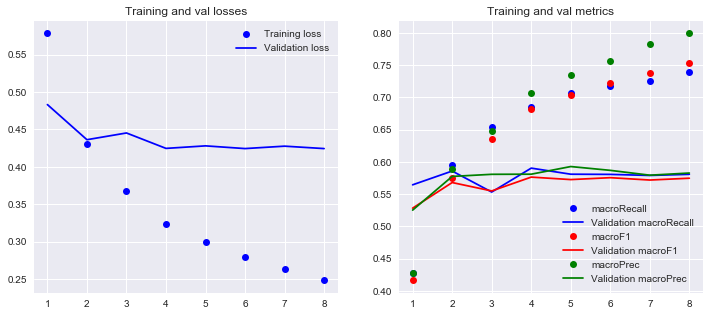

In [47]:
model.plot()

---

In [58]:
layers = [Embedding(input_dim=num_words, output_dim=50, input_length=padded_length, mask_zero=False),
          Dropout(0.5),
          Conv1D(24, 3),
          Conv1D(24, 3),
          Flatten()
         ]

In [59]:
model = BlackBox(layers=layers, loss=loss, batch_size=batch_size, optimizer=optimizer, epochs=epochs,\
                 verbose=1,\
                 callbacks=None,\
                 )
model.summary()

loss=fuzzy_macroF1_flip, batch_size=500, optimizer=nadam, explicit-class-weights: False, embedd-trainable: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 679, 50)           13865200  
_________________________________________________________________
dropout_23 (Dropout)         (None, 679, 50)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 677, 24)           3624      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 675, 24)           1752      
_________________________________________________________________
flatten_9 (Flatten)          (None, 16200)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 6)                 97206     
Total params: 13,967,782
Train

In [60]:
model.fit()

loss=fuzzy_macroF1_flip, batch_size=500, optimizer=nadam, explicit-class-weights: False, embedd-trainable: True
Train on 500000 samples, validate on 200000 samples
Epoch 1/8
500000/500000 [==============================] - 1715s 3ms/step - loss: 0.4352 - macroPrec: 0.5783 - macroF1: 0.5641 - macroRecall: 0.5880 - val_loss: 0.4925 - val_macroPrec: 0.5723 - val_macroF1: 0.5076 - val_macroRecall: 0.6384
Epoch 2/8
500000/500000 [==============================] - 1622s 3ms/step - loss: 0.3884 - macroPrec: 0.6268 - macroF1: 0.6116 - macroRecall: 0.6446 - val_loss: 0.4272 - val_macroPrec: 0.6203 - val_macroF1: 0.5726 - val_macroRecall: 0.5696
Epoch 3/8
500000/500000 [==============================] - 1512s 3ms/step - loss: 0.3914 - macroPrec: 0.6286 - macroF1: 0.6085 - macroRecall: 0.6297 - val_loss: 0.3769 - val_macroPrec: 0.6385 - val_macroF1: 0.6232 - val_macroRecall: 0.6280
Epoch 4/8
500000/500000 [==============================] - 1517s 3ms/step - loss: 0.4152 - macroPrec: 0.6305 - macro

In [61]:
model.Ksave()
model.save_hist()

loss=fuzzy_macroF1_flip, batch_size=500, optimizer=nadam, explicit-class-weights: False, embedd-trainable: True


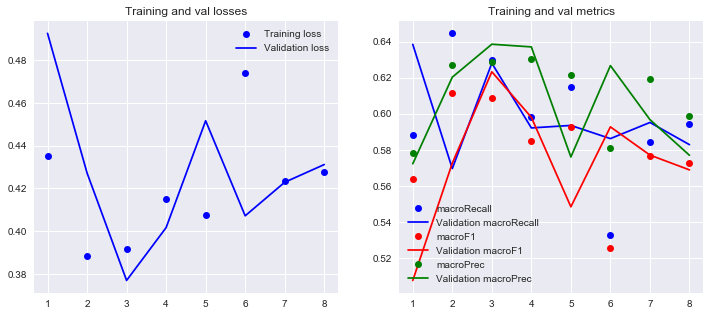

In [62]:
model.plot()

loss=fuzzy_macroF1_flip, batch_size=500, optimizer=nadam, explicit-class-weights: False, embedd-trainable: True


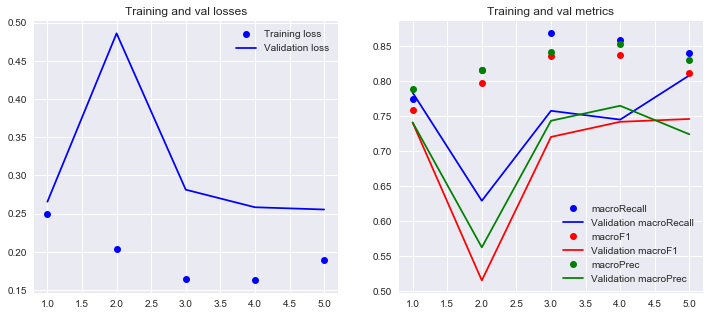

In [41]:
model.plot()

---

In [14]:
layers = [Dropout(0.5), 
          SimpleRNN(100)
         ]

In [15]:
model = BlackBox(layers=layers, loss=loss, batch_size=batch_size, optimizer=optimizer, epochs=epochs,\
                 verbose=1,\
                 callbacks=None,\
                 embedd=embedd_file, embedd_dims=[num_words, 50, padded_length], train_weights=True,\
                 mask_zeros=True)
model.fit()
model.Ksave()
model.save_hist()

loss=fuzzy_macroF1_flip, batch_size=300, optimizer=nadam, explicit-class-weights: False, embedd-trainable: True
Train on 30000 samples, validate on 30000 samples
Epoch 1/5
30000/30000 [==============================] - 224s 7ms/step - loss: 0.6254 - macroPrec: 0.4144 - macroF1: 0.3743 - macroRecall: 0.3685 - val_loss: 0.5460 - val_macroPrec: 0.4736 - val_macroF1: 0.4562 - val_macroRecall: 0.4681
Epoch 2/5
30000/30000 [==============================] - 226s 8ms/step - loss: 0.5301 - macroPrec: 0.5048 - macroF1: 0.4791 - macroRecall: 0.4822 - val_loss: 0.5318 - val_macroPrec: 0.4885 - val_macroF1: 0.4692 - val_macroRecall: 0.4771
Epoch 3/5
30000/30000 [==============================] - 231s 8ms/step - loss: 0.5731 - macroPrec: 0.4614 - macroF1: 0.4310 - macroRecall: 0.4342 - val_loss: 0.5890 - val_macroPrec: 0.4537 - val_macroF1: 0.4162 - val_macroRecall: 0.4160
Epoch 4/5
30000/30000 [==============================] - 236s 8ms/step - loss: 0.5378 - macroPrec: 0.4965 - macroF1: 0.4682 - m

loss=fuzzy_macroF1_flip, batch_size=300, optimizer=nadam, explicit-class-weights: False, embedd-trainable: True


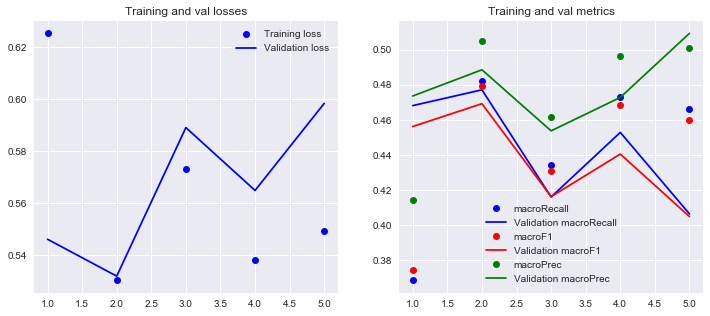

In [16]:
model.plot()

---

In [ ]:
layers = [Dropout(0.5), 
          LSTM(100)
         ]

In [ ]:
model = BlackBox(layers=layers, loss=loss, batch_size=batch_size, optimizer=optimizer, epochs=epochs,\
                 verbose=1,\
                 callbacks=None,\
                 embedd=embedd_file, embedd_dims=[num_words, 50, padded_length], train_weights=True,\
                 mask_zeros=True)
model.fit()
model.Ksave()
model.save_hist()

In [ ]:
model.plot()

---


### End